In [1]:
import cv2
import os
import random
import glob as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import *

In [2]:
zip_file_path = 'MoodforMusic.zip'
extract_to_path = 'MoodforMusic'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)
extracted_files = os.listdir(extract_to_path)
print(extracted_files)

['data_moods.csv', 'test', 'train']


In [3]:
train_data="../MoodforMusic/train/"
test_data="../MoodforMusic/test/"

def Classes_Count(path, name):
    Classes_Dict={}
    for Class in os.listdir(path):
        Full_Path = path+Class
        Classes_Dict[Class]=len(os.listdir(Full_Path))
    df=pd.DataFrame(Classes_Dict, index=[name])
    return df

Train_Count= Classes_Count(train_data, "Train").transpose().sort_values(by="Train",ascending=False)
Test_Count= Classes_Count(test_data, "Test").transpose().sort_values(by="Test",ascending=False)

In [4]:
pd.concat([Train_Count,Test_Count], axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1248
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


<Axes: >

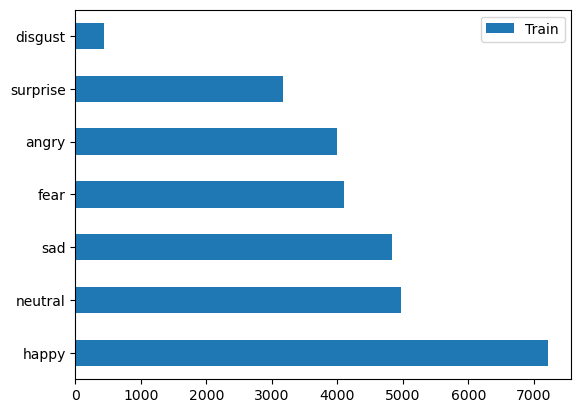

In [5]:
Train_Count.plot(kind="barh")

<Axes: >

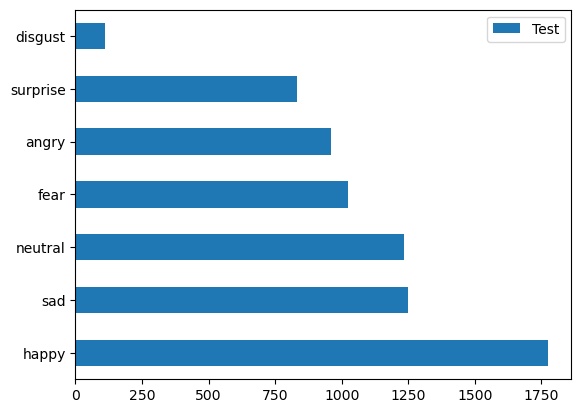

In [6]:
Test_Count.plot(kind="barh")

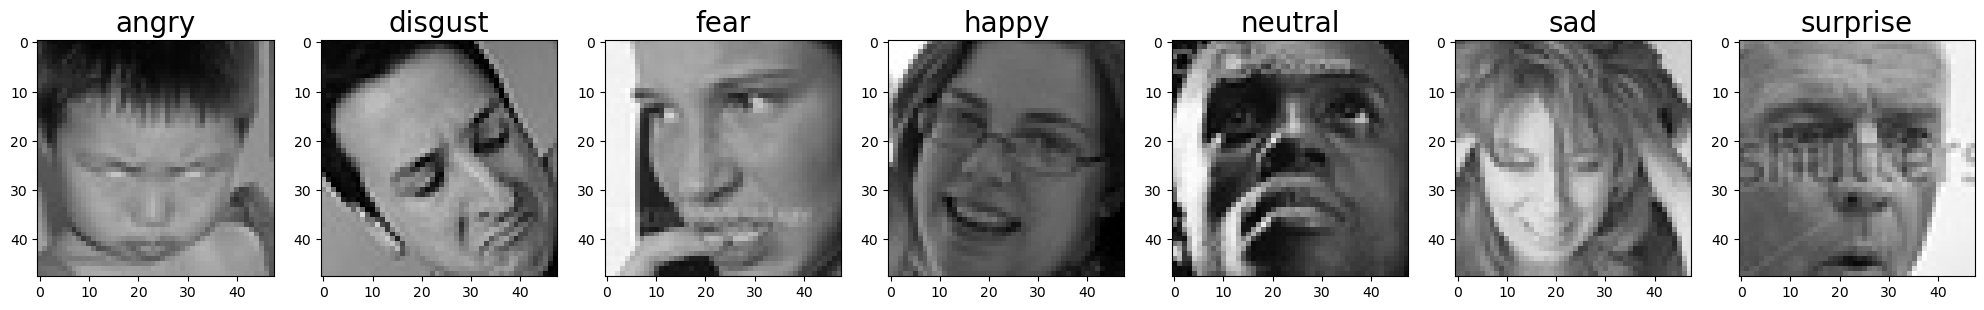

In [7]:
plt.style.use("default")
plt.figure(figsize=(25,8))
image_count=1
BASE_URL = "../MoodforMusic/train/"

for directory in os.listdir(BASE_URL):
    if directory[0] != ".":
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1,7, image_count)
                image_count+=1
                image=cv2.imread(BASE_URL+directory+"/"+file)
                plt.imshow(image)
                plt.title(directory, fontsize=20)

In [8]:
img_shape=224
batch_size=8
train_data_path="../MoodforMusic/train/"
test_data_path="../MoodforMusic/test/"

In [9]:
train_preprocessor = ImageDataGenerator(
    rescale=1.0/255.0, 
    rotation_range=10, 
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest")

test_preprocessor = ImageDataGenerator(
    rescale=1.0/255.0)

training_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode='categorical',
    target_size=(img_shape, img_shape),
    batch_size=batch_size,
    color_mode="rgb",
    shuffle=True,
    subset="training"
)

testing_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode='categorical',
    target_size=(img_shape, img_shape),
    batch_size=batch_size,
    color_mode="rgb",
    shuffle=False,
)

Found 28709 images belonging to 7 classes.
Found 7179 images belonging to 7 classes.


In [10]:
ResNet50V2=tf.keras.applications.ResNet50V2(input_shape=(224,224,3),include_top=False,weights="imagenet")

In [11]:
ResNet50V2.trainable=True
for layer in ResNet50V2.layers[:-50]:
    layer.trainable=False

In [12]:
def Create_ResNet50V2_Model():
    model=keras.Sequential([ResNet50V2,
                     Dropout(0.25),
                     BatchNormalization(),
                     Flatten(),
                     Dense(64, activation="relu"),
                     BatchNormalization(),
                     Dropout(0.5),
                     Dense(7, activation="softmax")])
    return model

In [13]:
ResNet50V2_Model=Create_ResNet50V2_Model()
ResNet50V2_Model.summary()
ResNet50V2_Model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,996,295 (114.43 MB)

 Trainable params: 22,779,527 (86.90 MB)

 Non-trainable params: 7,216,768 (27.53 MB)

In [14]:
checkpoint_path="ResNet50V2_Model_Checkpoint.keras"
Checkpoint=ModelCheckpoint(checkpoint_path,monitor="val_accuracy",save_best_only=True)
Early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1)
Reducing_LR=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=2,min_lr=0.000005, verbose=1)
callbacks=[Early_stopping, Reducing_LR]
steps_per_epoch=training_data.n//training_data.batch_size
validation_steps=testing_data.n//testing_data.batch_size

In [ ]:
ResNet50V2_history=ResNet50V2_Model.fit(training_data,validation_data=testing_data,epochs=15, batch_size=batch_size, 
                          callbacks=callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/15
3588/3588 ━━━━━━━━━━━━━━━━━━━━ 2162s 597ms/step - accuracy: 0.2707 - loss: 2.0640 - val_accuracy: 0.4280 - val_loss: 1.5685 - learning_rate: 0.0010
Epoch 2/15
3588/3588 ━━━━━━━━━━━━━━━━━━━━ 287s 80ms/step - accuracy: 0.3750 - loss: 2.1834 - val_accuracy: 0.4330 - val_loss: 1.5616 - learning_rate: 0.0010
Epoch 3/15
3588/3588 ━━━━━━━━━━━━━━━━━━━━ 2356s 657ms/step - accuracy: 0.3840 - loss: 1.6151 - val_accuracy: 0.4498 - val_loss: 1.5639 - learning_rate: 0.0010
Epoch 4/15
   1/3588 ━━━━━━━━━━━━━━━━━━━━ 38:26 643ms/step - accuracy: 0.5000 - loss: 1.5781
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
3588/3588 ━━━━━━━━━━━━━━━━━━━━ 291s 81ms/step - accuracy: 0.5000 - loss: 1.5781 - val_accuracy: 0.4489 - val_loss: 1.5629 - learning_rate: 0.0010
Epoch 5/15
3588/3588 ━━━━━━━━━━━━━━━━━━━━ 2275s 634ms/step - accuracy: 0.4109 - loss: 1.5429 - val_accuracy: 0.4912 - val_loss: 1.3566 - learning_rate: 2.0000e-04
Epoch 6/15
3588/3588 ━━━━━━━━━━━━━━━━━━━━ 353s

In [ ]:
ResNet50V2_Model.save('ResNet50V2_Model.keras')

In [ ]:
test_loss, test_acc = ResNet50V2_Model.evaluate(testing_data)
print(f'Test accuracy: {test_acc:.2f}')

In [ ]:
def plot_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(loss))
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()
    
    plt.show()


In [ ]:
plot_curves(ResNet50V2_history)

In [ ]:
ResNet50V2_Predictions=ResNet50V2_Model.predict(testing_data)
ResNet50V2_Predictions=np.argmax(ResNet50V2_Predictions,axis=1)

In [ ]:
fig, ax=plt.subplots(figsize=(15,10))
cm=confusion_matrix(testing_data.labels,ResNet50V2_Predictions)
sns.heatmap(cm, annot=True, fmt="g", ax=ax)
ax.set_xlabel("predicted labels",fontsize=15, fontweight="bold")
ax.set_ylabel("True labels",fontsize=15, fontweight="bold")
ax.set_title("ResNet50V2 Confusion Matrix",fontsize=20, fontweight="bold")

In [ ]:
Emotion_Classes=["Angry",
                "Disgust",
                "Fear",
                "Happy",
                "Neutral",
                "Sad",
                "Surprise"]

In [ ]:
test_preprocessor=ImageDataGenerator(rescale=1/255.,)
test_generator=test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

In [ ]:
Random_batch = np.random.randint(0, len(test_generator) - 1)
Random_Img_Index = np.random.randint(0, batch_size - 1, 10)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10), subplot_kw={"xticks": [], "yticks": []})

for i, ax in enumerate(axes.flat):
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])
    Model_Prediction = np.argmax(ResNet50V2_Model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0))
    ax.imshow(Random_Img)
    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()


**MOODFORMUSIC APP**

In [ ]:
import urllib.request

url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"
filename = "haarcascade_frontalface_default.xml"
urllib.request.urlretrieve(url, filename)
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")


In [ ]:
Music_Player=pd.read_csv("../MoodforMusic/data_moods.csv")
Music_Player=Music_Player[["name","artist","mood","popularity"]]
Music_Player.head()

In [ ]:
Music_Player["mood"].value_counts()

In [ ]:
Music_Player["popularity"].value_counts()

In [ ]:
Play=Music_Player[Music_Player["mood"]=="Calm"]
Play=Play.sort_values(by="popularity",ascending=False)
Play=Play[:5].reset_index(drop=True)
display(Play)

In [ ]:
def Recommend_Songs(pred_class):
    mood_map = {
        "Disgust": "Sad",
        "Happy": "Happy",
        "Sad": "Happy",
        "Fear": "Calm",
        "Angry": "Calm",
        "Surprise": "Energetic",
        "Neutral": "Energetic"
    }

    mood = mood_map.get(pred_class, "Happy")  # Default to "Happy" if pred_class not found
    Play = Music_Player[Music_Player["mood"] == mood]
    Play = Play.sort_values(by="popularity", ascending=False)
    Play = Play[:5].reset_index(drop=True)
    display(Play)

In [ ]:
def load_and_prep_image(filename, img_shape=224):
    # Load the image
    img = cv2.imread(filename)
    if img is None:
        print(f"Error: Unable to load image at path {filename}")
        return None
    
    # Convert the image to grayscale
    GrayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = faceCascade.detectMultiScale(GrayImg, 1.1, 4)
    for x, y, w, h in faces:
        roi_GrayImg = img[y: y + h, x: x + w]
        roi_Img = img[y: y + h, x: x + w]
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # Display the detected face
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # Further face detection within the ROI
        faces = faceCascade.detectMultiScale(roi_Img, 1.1, 4)
        if len(faces) == 0:
            print("No additional faces detected within the ROI")
        else:
            for (ex, ey, ew, eh) in faces:
                img = roi_Img[ey: ey + eh, ex: ex + ew]

    # Convert the image to RGB
    RGBImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize the image
    RGBImg = cv2.resize(RGBImg, (img_shape, img_shape))
    
    # Normalize the image
    RGBImg = RGBImg / 255.0

    return RGBImg


In [ ]:
def pred_and_plot(filename, class_names):
    # Load and prepare the image
    img = load_and_prep_image(filename)
    
    # Check if the image is loaded correctly
    if img is None:
        print(f"Error: Unable to process the image at path {filename}")
        return
    
    # Make prediction
    pred = ResNet50V2_Model.predict(np.expand_dims(img, axis=0))
    pred_class = class_names[pred.argmax()]
    
    # Plot the image with prediction
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis('off')  # Remove the axis
    
    # Display the plot
    plt.show()
    
    # Recommend songs based on the prediction
    Recommend_Songs(pred_class)

In [ ]:
pred_and_plot("MoodforMusic/test/happy/PrivateTest_10516065.jpg".replace("\\", "/"), Emotion_Classes)

In [ ]:
pred_and_plot("MoodforMusic/test/sad/PrivateTest_11080550.jpg".replace("\\", "/"), Emotion_Classes)

In [ ]:
pred_and_plot("MoodforMusic/test/neutral/PrivateTest_11239107.jpg".replace("\\", "/"), Emotion_Classes)

In [ ]:
pred_and_plot("MoodforMusic/test/surprise/PrivateTest_11445412.jpg".replace("\\", "/"), Emotion_Classes)